# The Acrobot (v-1) Problem

Acrobot is a 2-link pendulum with only the second joint actuated.

Intitially, both links point downwards. The goal is to swing the
end-effector at a height at least the length of one link above the base.
Both links can swing freely and can pass by each other, i.e., they don't
collide when they have the same angle.

## States
The state consists of the sin() and cos() of the two rotational joint
angles and the joint angular velocities :
[cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2].

For the first link, an angle of 0 corresponds to the link pointing downwards.
The angle of the second link is relative to the angle of the first link.
An angle of 0 corresponds to having the same angle between the two links.
A state of [1, 0, 1, 0, ..., ...] means that both links point downwards.

## Actions
The action is either applying +1, 0 or -1 torque on the joint between
the two pendulum links.

FPS = 15

In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
from utils.DQN_model import DQN_CNN
from PIL import Image

import time
import pickle
import random
from itertools import count
from utils.Schedule import LinearSchedule, ExponentialSchedule
from utils.Agent import AcrobotAgent, preprocess_frame

In [2]:
def calc_moving_average(lst, window_size=10):
    '''
    This function calculates the moving average of `lst` over
    `window_size` samples.
    Parameters:
        arr: list (list)
        window_size: size over which to average (int)
    Returns:
        mean_arr: array with the averages (np.array)
    '''
    assert len(lst) >= window_size
    mean_arr = []
    for j in range(1, window_size):
        mean_arr.append(np.mean(lst[:j]))
    i = 0
    while i != (len(lst) - window_size + 1):
        mean_arr.append(np.mean(lst[i : i + window_size]))
        i += 1
    return np.array(mean_arr)

def plot_rewards(episode_rewards, window_size=10, title=''):
    '''
    This function plots the rewards vs. episodes and the mean rewards vs. episodes.
    The mean is taken over `windows_size` episodes.
    Parameters:
        episode_rewards: list of all the rewards (list)
    '''
    num_episodes = len(episode_rewards)
    mean_rewards = calc_moving_average(episode_rewards, window_size)
    plt.plot(list(range(num_episodes)), episode_rewards, label='rewards')
    plt.plot(list(range(num_episodes)), mean_rewards, label='mean_rewards')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()
    
# Play
def play_acrobot(env, agent, num_episodes=5):
    '''
    This function plays the Acrobot-v1 environment given an agent.
    Parameters:
        agent: the agent that holds the policy (AcrobotAgent)
        num_episodes: number of episodes to play
    '''
    if agent.obs_represent == 'frame_seq':
        print("Playing Acrobot-v1 with " , agent.name ,"agent using Frame Sequence")
        start_time = time.time()
        for episode in range(num_episodes):
            episode_start_time = time.time()
            env.reset()
            last_obs = preprocess_frame(env, mode='atari', render=True)
            episode_reward = 0
            for t in count():
                ### Step the env and store the transition
                # Store lastest observation in replay memory and last_idx can be used to store action, reward, done
                last_idx = agent.replay_buffer.store_frame(last_obs)
                # encode_recent_observation will take the latest observation
                # that you pushed into the buffer and compute the corresponding
                # input that should be given to a Q network by appending some
                # previous frames.
                recent_observation = agent.replay_buffer.encode_recent_observation()
                action = agent.predict_action(recent_observation)
                _ , reward, done, _ = env.step(action)
                episode_reward += reward
                # Store other info in replay memory
                agent.replay_buffer.store_effect(last_idx, action, reward, done)
                if done:
                    print("Episode: ", episode, " Done, Reward: ", episode_reward, 
                          " Episode Time: %.2f secs" % (time.time() - episode_start_time))
                    break
                last_obs = preprocess_frame(env, mode='atari', render=True)
        env.close()
    else:
        # mode == 'frame diff'
        print("Playing Acrobot-v1 with " , agent.name ,"agent using Frame Difference")
        start_time = time.time()
        for episode in range(num_episodes):
            print("### Episode ", episode + 1, " ###")
            episode_start_time = time.time()
            env.reset()
            last_obs = preprocess_frame(env, mode='control', render=True)
            current_obs = preprocess_frame(env, mode='control', render=True)
            state = current_obs - last_obs
            episode_reward = 0
            for t in count():
                action = agent.predict_action(state)
                _ , reward, done, _ = env.step(action)
                episode_reward += reward
                if done:
                    print("Episode: ", episode + 1, " Done, Reward: ",
                          episode_reward,
                         " Episode Time: %.2f secs" % (time.time() - episode_start_time))
                    break
                last_obs = current_obs
                current_obs = preprocess_frame(env, mode='control', render=True)
                state = current_obs - last_obs
        env.close()

In [7]:
exp_schedule = ExponentialSchedule(decay_rate=100)
lin_schedule = LinearSchedule(total_timesteps=1000)

In [4]:
gym.logger.set_level(40)
env = gym.make("Acrobot-v1")

In [12]:
agent = AcrobotAgent(env,
                     name='frame_seq_rep',
                     frame_history_len = 4,
                     exploration=lin_schedule,
                     steps_to_start_learn=10000,
                     target_update_freq=500,
                     learning_rate=0.00025,
                     clip_grads=True,
                     use_batch_norm=False)

Using Frame-Sequence representation for states
Checkpoint loaded successfully from  ./acrobot_agent_ckpt\acrobot_agent_frame_seq_rep.pth
Created Agent for Acrobot-v1


In [8]:
mean_episode_reward = -float('nan')
best_mean_episode_reward = -float('inf')
last_obs = env.reset()
LOG_EVERY_N_STEPS = 5000
batch_size = 32 # 32
num_episodes = 100000

In [9]:
with open('./acrobot_agent_ckpt/frame_seq_training.status', 'rb') as fp:
    training_status = pickle.load(fp)
    mean_episode_reward = training_status['mean_episode_reward']
    best_mean_episode_reward = training_status['best_mean_episode_reward']
    episode_durations = training_status['episode_durations'] 
    episodes_rewards = training_status['episodes_rewards']
    total_steps = training_status['total_steps']

In [13]:
# episode_durations = []
# episodes_rewards = []
# total_steps = 0
start_time = time.time()
for episode in range(num_episodes):
    episode_start_time = time.time()
    env.reset()
    last_obs = preprocess_frame(env, mode='atari', render=True)
    episode_reward = 0
    agent.episodes_seen += 1
    for t in count():
        agent.steps_count += 1
        total_steps += 1
        ### Step the env and store the transition
        # Store lastest observation in replay memory and last_idx can be used to store action, reward, done
        last_idx = agent.replay_buffer.store_frame(last_obs)
        # encode_recent_observation will take the latest observation
        # that you pushed into the buffer and compute the corresponding
        # input that should be given to a Q network by appending some
        # previous frames.
        recent_observation = agent.replay_buffer.encode_recent_observation()
        action = agent.select_greedy_action(recent_observation, use_episode=True)
        # Advance one step
        _ , reward, done, _ = env.step(action)
        episode_reward += reward
        agent.replay_buffer.store_effect(last_idx, action, reward, done)
        ### Perform experience replay and train the network.
        # Note that this is only done if the replay buffer contains enough samples
        # for us to learn something useful -- until then, the model will not be
        # initialized and random actions should be taken
        agent.learn(batch_size)
        ### Log progress and keep track of statistics
        if len(episodes_rewards) > 0:
            mean_episode_reward = np.mean(episodes_rewards[-100:])
        if len(episodes_rewards) > 100:
            best_mean_episode_reward = max(best_mean_episode_reward, mean_episode_reward)
        if total_steps % LOG_EVERY_N_STEPS == 0 and total_steps > agent.steps_to_start_learn:
            print("Timestep %d" % (agent.steps_count,))
            print("mean reward (100 episodes) %f" % mean_episode_reward)
            print("best mean reward %f" % best_mean_episode_reward)
            print("episodes %d" % len(episodes_rewards))
            print("exploration value %f" % agent.epsilon)
            total_time = time.time() - start_time
            print("time since start %.2f seconds" % total_time)
            training_status = {}
            training_status['mean_episode_reward'] = mean_episode_reward
            training_status['best_mean_episode_reward'] = best_mean_episode_reward
            training_status['episode_durations'] = episode_durations
            training_status['episodes_rewards'] = episodes_rewards
            training_status['total_steps'] = total_steps
            with open('./acrobot_agent_ckpt/frame_seq_training.status', 'wb') as fp:
                pickle.dump(training_status, fp)
        # Resets the environment when reaching an episode boundary.
        if done:
            episode_durations.append(t + 1)
            episodes_rewards.append(episode_reward)
            print("Episode: ", agent.episodes_seen, " Done, Reward: ", episode_reward,
                  " Step: ", agent.steps_count, " Episode Time: %.2f secs" % (time.time() - episode_start_time))
            break
        last_obs = preprocess_frame(env, mode='atari', render=True)
#         print(last_obs)
print("Training Complete!")
env.close()

Episode:  6064  Done, Reward:  -500.0  Step:  3006628  Episode Time: 11.20 secs
Episode:  6065  Done, Reward:  -500.0  Step:  3007128  Episode Time: 10.43 secs
Episode:  6066  Done, Reward:  -500.0  Step:  3007628  Episode Time: 10.43 secs
Episode:  6067  Done, Reward:  -500.0  Step:  3008128  Episode Time: 10.42 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_seq_rep.pth
Episode:  6068  Done, Reward:  -500.0  Step:  3008628  Episode Time: 10.45 secs
Episode:  6069  Done, Reward:  -500.0  Step:  3009128  Episode Time: 10.44 secs
Episode:  6070  Done, Reward:  -500.0  Step:  3009628  Episode Time: 10.43 secs
Episode:  6071  Done, Reward:  -500.0  Step:  3010128  Episode Time: 10.44 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_seq_rep.pth
Episode:  6072  Done, Reward:  -500.0  Step:  3010628  Episode Time: 10.46 secs
Timestep 3010882
mean reward (100 episodes) -499.350000
best mean reward -483.880000
episodes 6053
explora

KeyboardInterrupt: 

In [6]:
play_acrobot(env, agent, num_episodes=5)

Playing Acrobot-v1 with  frame_seq_rep agent using Frame Sequence
Episode:  0  Done, Reward:  -500.0  Episode Time: 10.15 secs
Episode:  1  Done, Reward:  -500.0  Episode Time: 8.34 secs
Episode:  2  Done, Reward:  -500.0  Episode Time: 8.34 secs
Episode:  3  Done, Reward:  -500.0  Episode Time: 8.34 secs
Episode:  4  Done, Reward:  -500.0  Episode Time: 8.34 secs


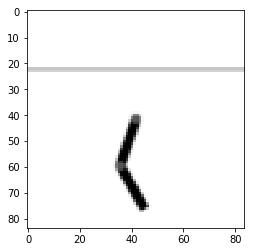

In [11]:
plt.imshow(last_obs[:,:,0], cmap='gray')

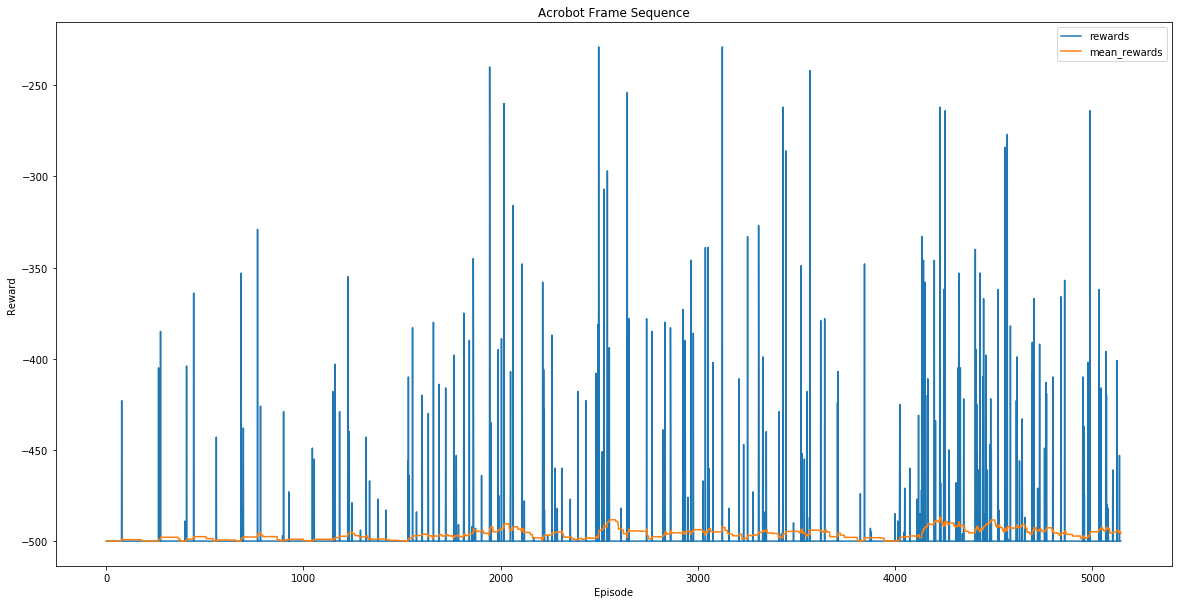

In [11]:
with open('./acrobot_agent_ckpt/frame_seq_training.status', 'rb') as fp:
    training_status = pickle.load(fp) 
    episodes_rewards = training_status['episodes_rewards']
    plt.rcParams['figure.figsize'] = (20, 10)
    plot_rewards(episodes_rewards, 100, title='Acrobot Frame Sequence')

In [4]:
# Frame Differenece
mean_episode_reward = -float('nan')
best_mean_episode_reward = -float('inf')
last_obs = env.reset()
LOG_EVERY_N_STEPS = 1000
batch_size = 128 # 32
num_episodes = 10000

In [5]:
agent = AcrobotAgent(env,
                     name='frame_diff',
                     exploration=lin_schedule,
                     steps_to_start_learn=2000,
                     target_update_freq=500,
                     learning_rate=0.003,
                     clip_grads=True,
                     use_batch_norm=True,
                     obs_represent='frame_diff')

Using Frame-Difference representation for states
Checkpoint loaded successfully from  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Created Agent for Acrobot-v1


In [17]:
with open('./acrobot_agent_ckpt/training.status', 'rb') as fp:
    training_status = pickle.load(fp)
    mean_episode_reward = training_status['mean_episode_reward']
    best_mean_episode_reward = training_status['best_mean_episode_reward']
    episode_durations = training_status['episode_durations'] 
    episodes_rewards = training_status['episodes_rewards']
    total_steps = training_status['total_steps']

In [14]:
# episode_durations = []
# episodes_rewards = []
# total_steps = 0
start_time = time.time()
for episode in range(num_episodes):
    episode_start_time = time.time()
    env.reset()
    last_obs = preprocess_frame(env, mode='control', render=True)
    current_obs = preprocess_frame(env, mode='control', render=True)
    state = current_obs - last_obs
    episode_reward = 0
    agent.episodes_seen += 1
#     agent.epsilon = agent.explore_schedule.value(agent.episodes_seen)
    for t in count():
        agent.steps_count += 1
        total_steps += 1
        ### Step the env and store the transition
        # Store lastest observation in replay memory and last_idx can be used to store action, reward, done
        last_idx = agent.replay_buffer.store_frame(state)
        # encode_recent_observation will take the latest observation
        # that you pushed into the buffer and compute the corresponding
        # input that should be given to a Q network by appending some
        # previous frames.
        recent_observation = agent.replay_buffer.encode_recent_observation()
        action = agent.select_greedy_action(recent_observation, use_episode=True)
        # Advance one step
        _ , reward, done, _ = env.step(action)
        episode_reward += reward
        agent.replay_buffer.store_effect(last_idx, action, reward, done)
        ### Perform experience replay and train the network.
        # Note that this is only done if the replay buffer contains enough samples
        # for us to learn something useful -- until then, the model will not be
        # initialized and random actions should be taken
        agent.learn(batch_size)
        ### Log progress and keep track of statistics
        if len(episodes_rewards) > 0:
            mean_episode_reward = np.mean(episodes_rewards[-100:])
        if len(episodes_rewards) > 100:
            best_mean_episode_reward = max(best_mean_episode_reward, mean_episode_reward)

        if total_steps % LOG_EVERY_N_STEPS == 0 and total_steps > agent.steps_to_start_learn:
            print("Timestep %d" % (agent.steps_count,))
            print("mean reward (100 episodes) %f" % mean_episode_reward)
            print("best mean reward %f" % best_mean_episode_reward)
            print("episodes %d" % len(episodes_rewards))
            print("exploration value %f" % agent.epsilon)
            total_time = time.time() - start_time
            print("time since start %.2f seconds" % total_time)
            training_status = {}
            training_status['mean_episode_reward'] = mean_episode_reward
            training_status['best_mean_episode_reward'] = best_mean_episode_reward
            training_status['episode_durations'] = episode_durations
            training_status['episodes_rewards'] = episodes_rewards
            training_status['total_steps'] = total_steps
            with open('./acrobot_agent_ckpt/frame_diff_training.status', 'wb') as fp:
                pickle.dump(training_status, fp)
        # Resets the environment when reaching an episode boundary.
        if done:
            episode_durations.append(t + 1)
            episodes_rewards.append(episode_reward)
            print("Episode: ", agent.episodes_seen, " Done, Reward: ",
                  episode_reward, " Step: ", agent.steps_count,
                 " Episode Time: %.2f secs" % (time.time() - episode_start_time))
            break
        last_obs = current_obs
        current_obs = preprocess_frame(env, mode='control', render=True)
        state = current_obs - last_obs
print("Training Complete!")
env.close()

Episode:  1587  Done, Reward:  -284.0  Step:  641117  Episode Time: 8.77 secs
Episode:  1588  Done, Reward:  -330.0  Step:  641448  Episode Time: 9.70 secs
Timestep 641832
mean reward (100 episodes) -376.370000
best mean reward -260.910000
episodes 1334
exploration value 0.245225
time since start 29.70 seconds
Episode:  1589  Done, Reward:  -428.0  Step:  641877  Episode Time: 12.53 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1590  Done, Reward:  -500.0  Step:  642377  Episode Time: 14.59 secs
Episode:  1591  Done, Reward:  -233.0  Step:  642611  Episode Time: 6.81 secs
Timestep 642832
mean reward (100 episodes) -374.940000
best mean reward -260.910000
episodes 1337
exploration value 0.243800
time since start 58.92 seconds
Episode:  1592  Done, Reward:  -427.0  Step:  643039  Episode Time: 12.51 secs
Episode:  1593  Done, Reward:  -234.0  Step:  643274  Episode Time: 6.88 secs
Episode:  1594  Done, Reward:  -301.0  Step:  643576  E

Episode:  1655  Done, Reward:  -110.0  Step:  656166  Episode Time: 3.81 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1656  Done, Reward:  -107.0  Step:  656274  Episode Time: 3.85 secs
Episode:  1657  Done, Reward:  -184.0  Step:  656459  Episode Time: 6.38 secs
Episode:  1658  Done, Reward:  -102.0  Step:  656562  Episode Time: 3.62 secs
Episode:  1659  Done, Reward:  -187.0  Step:  656750  Episode Time: 7.15 secs
Timestep 656832
mean reward (100 episodes) -253.820000
best mean reward -253.820000
episodes 1405
exploration value 0.211500
time since start 495.13 seconds
Episode:  1660  Done, Reward:  -148.0  Step:  656899  Episode Time: 6.17 secs
Episode:  1661  Done, Reward:  -174.0  Step:  657074  Episode Time: 6.63 secs
Episode:  1662  Done, Reward:  -163.0  Step:  657238  Episode Time: 5.63 secs
Episode:  1663  Done, Reward:  -150.0  Step:  657389  Episode Time: 4.56 secs
Episode:  1664  Done, Reward:  -128.0  Step:  657518  Epi

Episode:  1724  Done, Reward:  -241.0  Step:  670669  Episode Time: 7.46 secs
Timestep 670832
mean reward (100 episodes) -192.590000
best mean reward -191.500000
episodes 1470
exploration value 0.180625
time since start 962.99 seconds
Episode:  1725  Done, Reward:  -261.0  Step:  670931  Episode Time: 9.17 secs
Episode:  1726  Done, Reward:  -271.0  Step:  671203  Episode Time: 10.76 secs
Episode:  1727  Done, Reward:  -315.0  Step:  671519  Episode Time: 12.63 secs
Episode:  1728  Done, Reward:  -268.0  Step:  671788  Episode Time: 9.72 secs
Timestep 671832
mean reward (100 episodes) -195.800000
best mean reward -191.500000
episodes 1474
exploration value 0.178725
time since start 1001.22 seconds
Episode:  1729  Done, Reward:  -268.0  Step:  672057  Episode Time: 9.45 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1730  Done, Reward:  -277.0  Step:  672335  Episode Time: 9.65 secs
Episode:  1731  Done, Reward:  -309.0  Step:  672645 

Episode:  1789  Done, Reward:  -104.0  Step:  686116  Episode Time: 3.63 secs
Episode:  1790  Done, Reward:  -113.0  Step:  686230  Episode Time: 3.42 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1791  Done, Reward:  -194.0  Step:  686425  Episode Time: 6.62 secs
Episode:  1792  Done, Reward:  -176.0  Step:  686602  Episode Time: 6.34 secs
Episode:  1793  Done, Reward:  -204.0  Step:  686807  Episode Time: 9.01 secs
Timestep 686832
mean reward (100 episodes) -224.770000
best mean reward -191.500000
episodes 1539
exploration value 0.147850
time since start 1512.94 seconds
Episode:  1794  Done, Reward:  -249.0  Step:  687057  Episode Time: 10.70 secs
Episode:  1795  Done, Reward:  -218.0  Step:  687276  Episode Time: 6.99 secs
Episode:  1796  Done, Reward:  -122.0  Step:  687399  Episode Time: 3.73 secs
Episode:  1797  Done, Reward:  -165.0  Step:  687565  Episode Time: 4.90 secs
Episode:  1798  Done, Reward:  -158.0  Step:  687724  E

Episode:  1855  Done, Reward:  -151.0  Step:  701986  Episode Time: 4.50 secs
Episode:  1856  Done, Reward:  -165.0  Step:  702152  Episode Time: 5.20 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1857  Done, Reward:  -289.0  Step:  702442  Episode Time: 9.85 secs
Timestep 702832
mean reward (100 episodes) -225.240000
best mean reward -191.500000
episodes 1603
exploration value 0.117450
time since start 2053.39 seconds
Episode:  1858  Done, Reward:  -500.0  Step:  702942  Episode Time: 18.43 secs
Episode:  1859  Done, Reward:  -500.0  Step:  703442  Episode Time: 14.93 secs
Timestep 703832
mean reward (100 episodes) -231.330000
best mean reward -191.500000
episodes 1605
exploration value 0.116500
time since start 2084.41 seconds
Episode:  1860  Done, Reward:  -500.0  Step:  703942  Episode Time: 16.44 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1861  Done, Reward:  -500.0  Step: 

Episode:  1922  Done, Reward:  -500.0  Step:  717285  Episode Time: 15.09 secs
Episode:  1923  Done, Reward:  -500.0  Step:  717785  Episode Time: 18.78 secs
Timestep 717832
mean reward (100 episodes) -232.210000
best mean reward -191.500000
episodes 1669
exploration value 0.086100
time since start 2555.34 seconds
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1924  Done, Reward:  -500.0  Step:  718285  Episode Time: 16.89 secs
Episode:  1925  Done, Reward:  -500.0  Step:  718785  Episode Time: 15.04 secs
Timestep 718832
mean reward (100 episodes) -235.980000
best mean reward -191.500000
episodes 1671
exploration value 0.085150
time since start 2586.81 seconds
Episode:  1926  Done, Reward:  -500.0  Step:  719285  Episode Time: 18.33 secs
Episode:  1927  Done, Reward:  -500.0  Step:  719785  Episode Time: 18.55 secs
Timestep 719832
mean reward (100 episodes) -237.290000
best mean reward -191.500000
episodes 1673
exploration value 0.084200
t

Episode:  1989  Done, Reward:  -135.0  Step:  732174  Episode Time: 4.04 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1990  Done, Reward:  -105.0  Step:  732280  Episode Time: 3.25 secs
Episode:  1991  Done, Reward:  -500.0  Step:  732780  Episode Time: 15.70 secs
Timestep 732832
mean reward (100 episodes) -201.770000
best mean reward -191.500000
episodes 1737
exploration value 0.053800
time since start 3070.62 seconds
Episode:  1992  Done, Reward:  -500.0  Step:  733280  Episode Time: 18.25 secs
Episode:  1993  Done, Reward:  -500.0  Step:  733780  Episode Time: 18.34 secs
Timestep 733832
mean reward (100 episodes) -209.070000
best mean reward -191.500000
episodes 1739
exploration value 0.052850
time since start 3107.04 seconds
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  1994  Done, Reward:  -500.0  Step:  734280  Episode Time: 16.14 secs
Episode:  1995  Done, Reward:  -180.0  Step:

Timestep 748832
mean reward (100 episodes) -236.130000
best mean reward -191.500000
episodes 1797
exploration value 0.050000
time since start 3630.97 seconds
Episode:  2052  Done, Reward:  -500.0  Step:  749147  Episode Time: 18.76 secs
Episode:  2053  Done, Reward:  -169.0  Step:  749317  Episode Time: 5.36 secs
Episode:  2054  Done, Reward:  -269.0  Step:  749587  Episode Time: 8.14 secs
Episode:  2055  Done, Reward:  -114.0  Step:  749702  Episode Time: 4.02 secs
Timestep 749832
mean reward (100 episodes) -239.470000
best mean reward -191.500000
episodes 1801
exploration value 0.050000
time since start 3664.87 seconds
Episode:  2056  Done, Reward:  -239.0  Step:  749942  Episode Time: 9.26 secs
Episode:  2057  Done, Reward:  -238.0  Step:  750181  Episode Time: 9.05 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2058  Done, Reward:  -476.0  Step:  750658  Episode Time: 15.57 secs
Timestep 750832
mean reward (100 episodes) -241.2200

Episode:  2109  Done, Reward:  -113.0  Step:  766919  Episode Time: 3.62 secs
Episode:  2110  Done, Reward:  -107.0  Step:  767027  Episode Time: 3.80 secs
Episode:  2111  Done, Reward:  -229.0  Step:  767257  Episode Time: 7.58 secs
Episode:  2112  Done, Reward:  -325.0  Step:  767583  Episode Time: 12.30 secs
Episode:  2113  Done, Reward:  -235.0  Step:  767819  Episode Time: 9.66 secs
Timestep 767832
mean reward (100 episodes) -274.860000
best mean reward -191.500000
episodes 1859
exploration value 0.050000
time since start 4293.28 seconds
Episode:  2114  Done, Reward:  -147.0  Step:  767967  Episode Time: 6.30 secs
Episode:  2115  Done, Reward:  -193.0  Step:  768161  Episode Time: 7.97 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2116  Done, Reward:  -343.0  Step:  768505  Episode Time: 10.86 secs
Episode:  2117  Done, Reward:  -303.0  Step:  768809  Episode Time: 9.24 secs
Timestep 768832
mean reward (100 episodes) -277.870000

Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2171  Done, Reward:  -320.0  Step:  784379  Episode Time: 9.88 secs
Episode:  2172  Done, Reward:  -279.0  Step:  784659  Episode Time: 10.30 secs
Timestep 784832
mean reward (100 episodes) -279.920000
best mean reward -191.500000
episodes 1918
exploration value 0.050000
time since start 4895.58 seconds
Episode:  2173  Done, Reward:  -269.0  Step:  784929  Episode Time: 10.40 secs
Episode:  2174  Done, Reward:  -358.0  Step:  785288  Episode Time: 13.35 secs
Episode:  2175  Done, Reward:  -379.0  Step:  785668  Episode Time: 12.64 secs
Timestep 785832
mean reward (100 episodes) -279.420000
best mean reward -191.500000
episodes 1921
exploration value 0.050000
time since start 4931.34 seconds
Episode:  2176  Done, Reward:  -213.0  Step:  785882  Episode Time: 8.30 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2177  Done, Reward:  -450.0  Step:

Episode:  2235  Done, Reward:  -301.0  Step:  800069  Episode Time: 10.48 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2236  Done, Reward:  -500.0  Step:  800569  Episode Time: 19.50 secs
Timestep 800832
mean reward (100 episodes) -257.440000
best mean reward -191.500000
episodes 1982
exploration value 0.050000
time since start 5477.38 seconds
Episode:  2237  Done, Reward:  -500.0  Step:  801069  Episode Time: 17.56 secs
Episode:  2238  Done, Reward:  -500.0  Step:  801569  Episode Time: 18.04 secs
Timestep 801832
mean reward (100 episodes) -262.850000
best mean reward -191.500000
episodes 1984
exploration value 0.050000
time since start 5513.26 seconds
Episode:  2239  Done, Reward:  -500.0  Step:  802069  Episode Time: 19.66 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2240  Done, Reward:  -500.0  Step:  802569  Episode Time: 17.50 secs
Timestep 802832
mean reward (100 episodes)

Timestep 815832
mean reward (100 episodes) -233.260000
best mean reward -191.500000
episodes 2046
exploration value 0.050000
time since start 6014.88 seconds
Episode:  2301  Done, Reward:  -438.0  Step:  815885  Episode Time: 17.09 secs
Episode:  2302  Done, Reward:  -149.0  Step:  816035  Episode Time: 5.76 secs
Episode:  2303  Done, Reward:  -161.0  Step:  816197  Episode Time: 6.38 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2304  Done, Reward:  -263.0  Step:  816461  Episode Time: 9.29 secs
Episode:  2305  Done, Reward:  -301.0  Step:  816763  Episode Time: 9.40 secs
Timestep 816832
mean reward (100 episodes) -223.950000
best mean reward -191.500000
episodes 2051
exploration value 0.050000
time since start 6050.12 seconds
Episode:  2306  Done, Reward:  -381.0  Step:  817145  Episode Time: 14.22 secs
Episode:  2307  Done, Reward:  -291.0  Step:  817437  Episode Time: 11.18 secs
Episode:  2308  Done, Reward:  -209.0  Step:  81764

Episode:  2368  Done, Reward:  -115.0  Step:  829899  Episode Time: 3.77 secs
Episode:  2369  Done, Reward:  -122.0  Step:  830022  Episode Time: 4.22 secs
Episode:  2370  Done, Reward:  -125.0  Step:  830148  Episode Time: 4.94 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2371  Done, Reward:  -135.0  Step:  830284  Episode Time: 5.21 secs
Episode:  2372  Done, Reward:  -136.0  Step:  830421  Episode Time: 5.17 secs
Episode:  2373  Done, Reward:  -140.0  Step:  830562  Episode Time: 5.58 secs
Episode:  2374  Done, Reward:  -132.0  Step:  830695  Episode Time: 5.20 secs
Episode:  2375  Done, Reward:  -130.0  Step:  830826  Episode Time: 5.00 secs
Timestep 830832
mean reward (100 episodes) -192.780000
best mean reward -191.500000
episodes 2121
exploration value 0.050000
time since start 6554.87 seconds
Episode:  2376  Done, Reward:  -112.0  Step:  830939  Episode Time: 4.29 secs
Episode:  2377  Done, Reward:  -109.0  Step:  831049  Ep

Episode:  2441  Done, Reward:  -176.0  Step:  842913  Episode Time: 6.89 secs
Episode:  2442  Done, Reward:  -131.0  Step:  843045  Episode Time: 5.09 secs
Episode:  2443  Done, Reward:  -104.0  Step:  843150  Episode Time: 3.93 secs
Episode:  2444  Done, Reward:  -97.0  Step:  843248  Episode Time: 3.74 secs
Episode:  2445  Done, Reward:  -146.0  Step:  843395  Episode Time: 5.74 secs
Episode:  2446  Done, Reward:  -142.0  Step:  843538  Episode Time: 5.13 secs
Episode:  2447  Done, Reward:  -163.0  Step:  843702  Episode Time: 5.20 secs
Timestep 843832
mean reward (100 episodes) -177.390000
best mean reward -175.770000
episodes 2193
exploration value 0.050000
time since start 7021.64 seconds
Episode:  2448  Done, Reward:  -175.0  Step:  843878  Episode Time: 5.38 secs
Episode:  2449  Done, Reward:  -97.0  Step:  843976  Episode Time: 3.03 secs
Episode:  2450  Done, Reward:  -123.0  Step:  844100  Episode Time: 3.71 secs
Episode:  2451  Done, Reward:  -131.0  Step:  844232  Episode Ti

Episode:  2510  Done, Reward:  -500.0  Step:  857733  Episode Time: 22.54 secs
Timestep 857832
mean reward (100 episodes) -209.440000
best mean reward -165.920000
episodes 2256
exploration value 0.050000
time since start 7842.54 seconds
Episode:  2511  Done, Reward:  -500.0  Step:  858233  Episode Time: 16.95 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2512  Done, Reward:  -392.0  Step:  858626  Episode Time: 13.61 secs
Timestep 858832
mean reward (100 episodes) -213.660000
best mean reward -165.920000
episodes 2258
exploration value 0.050000
time since start 7877.54 seconds
Episode:  2513  Done, Reward:  -382.0  Step:  859009  Episode Time: 15.47 secs
Episode:  2514  Done, Reward:  -462.0  Step:  859472  Episode Time: 19.62 secs
Episode:  2515  Done, Reward:  -340.0  Step:  859813  Episode Time: 11.50 secs
Timestep 859832
mean reward (100 episodes) -218.260000
best mean reward -165.920000
episodes 2261
exploration value 0.050000
t

Episode:  2579  Done, Reward:  -239.0  Step:  871321  Episode Time: 9.10 secs
Episode:  2580  Done, Reward:  -237.0  Step:  871559  Episode Time: 9.76 secs
Timestep 871832
mean reward (100 episodes) -209.530000
best mean reward -165.920000
episodes 2326
exploration value 0.050000
time since start 8372.15 seconds
Episode:  2581  Done, Reward:  -305.0  Step:  871865  Episode Time: 11.24 secs
Episode:  2582  Done, Reward:  -240.0  Step:  872106  Episode Time: 8.08 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2583  Done, Reward:  -255.0  Step:  872362  Episode Time: 8.68 secs
Episode:  2584  Done, Reward:  -140.0  Step:  872503  Episode Time: 4.88 secs
Episode:  2585  Done, Reward:  -123.0  Step:  872627  Episode Time: 4.90 secs
Episode:  2586  Done, Reward:  -117.0  Step:  872745  Episode Time: 4.93 secs
Timestep 872832
mean reward (100 episodes) -208.970000
best mean reward -165.920000
episodes 2332
exploration value 0.050000
time sin

Timestep 884832
mean reward (100 episodes) -195.270000
best mean reward -165.920000
episodes 2395
exploration value 0.050000
time since start 9136.95 seconds
Episode:  2650  Done, Reward:  -157.0  Step:  884851  Episode Time: 6.93 secs
Episode:  2651  Done, Reward:  -97.0  Step:  884949  Episode Time: 3.73 secs
Episode:  2652  Done, Reward:  -110.0  Step:  885060  Episode Time: 3.74 secs
Episode:  2653  Done, Reward:  -150.0  Step:  885211  Episode Time: 5.07 secs
Episode:  2654  Done, Reward:  -83.0  Step:  885295  Episode Time: 2.83 secs
Episode:  2655  Done, Reward:  -110.0  Step:  885406  Episode Time: 3.75 secs
Episode:  2656  Done, Reward:  -111.0  Step:  885518  Episode Time: 3.75 secs
Episode:  2657  Done, Reward:  -129.0  Step:  885648  Episode Time: 4.59 secs
Episode:  2658  Done, Reward:  -126.0  Step:  885775  Episode Time: 4.36 secs
Timestep 885832
mean reward (100 episodes) -192.920000
best mean reward -165.920000
episodes 2404
exploration value 0.050000
time since start 

Episode:  2721  Done, Reward:  -137.0  Step:  898130  Episode Time: 5.21 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2722  Done, Reward:  -128.0  Step:  898259  Episode Time: 4.85 secs
Episode:  2723  Done, Reward:  -234.0  Step:  898494  Episode Time: 8.06 secs
Episode:  2724  Done, Reward:  -247.0  Step:  898742  Episode Time: 8.28 secs
Timestep 898832
mean reward (100 episodes) -186.940000
best mean reward -165.920000
episodes 2470
exploration value 0.050000
time since start 9646.95 seconds
Episode:  2725  Done, Reward:  -297.0  Step:  899040  Episode Time: 9.98 secs
Episode:  2726  Done, Reward:  -226.0  Step:  899267  Episode Time: 8.13 secs
Episode:  2727  Done, Reward:  -310.0  Step:  899578  Episode Time: 12.45 secs
Timestep 899832
mean reward (100 episodes) -189.640000
best mean reward -165.920000
episodes 2473
exploration value 0.050000
time since start 9683.64 seconds
Episode:  2728  Done, Reward:  -264.0  Step:  899843 

Episode:  2794  Done, Reward:  -99.0  Step:  910821  Episode Time: 7.49 secs
Timestep 910832
mean reward (100 episodes) -186.090000
best mean reward -165.920000
episodes 2540
exploration value 0.050000
time since start 10464.45 seconds
Episode:  2795  Done, Reward:  -110.0  Step:  910932  Episode Time: 9.15 secs
Episode:  2796  Done, Reward:  -130.0  Step:  911063  Episode Time: 10.43 secs
Episode:  2797  Done, Reward:  -100.0  Step:  911164  Episode Time: 7.66 secs
Episode:  2798  Done, Reward:  -87.0  Step:  911252  Episode Time: 8.31 secs
Episode:  2799  Done, Reward:  -96.0  Step:  911349  Episode Time: 6.56 secs
Episode:  2800  Done, Reward:  -97.0  Step:  911447  Episode Time: 8.93 secs
Episode:  2801  Done, Reward:  -141.0  Step:  911589  Episode Time: 11.07 secs
Episode:  2802  Done, Reward:  -126.0  Step:  911716  Episode Time: 8.94 secs
Episode:  2803  Done, Reward:  -109.0  Step:  911826  Episode Time: 8.88 secs
Timestep 911832
mean reward (100 episodes) -164.630000
best mea

Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2869  Done, Reward:  -230.0  Step:  922341  Episode Time: 17.89 secs
Episode:  2870  Done, Reward:  -145.0  Step:  922487  Episode Time: 10.69 secs
Episode:  2871  Done, Reward:  -164.0  Step:  922652  Episode Time: 15.75 secs
Episode:  2872  Done, Reward:  -151.0  Step:  922804  Episode Time: 13.35 secs
Timestep 922832
mean reward (100 episodes) -148.600000
best mean reward -147.580000
episodes 2618
exploration value 0.050000
time since start 11385.83 seconds
Episode:  2873  Done, Reward:  -216.0  Step:  923021  Episode Time: 17.44 secs
Episode:  2874  Done, Reward:  -157.0  Step:  923179  Episode Time: 10.42 secs
Episode:  2875  Done, Reward:  -207.0  Step:  923387  Episode Time: 16.33 secs
Episode:  2876  Done, Reward:  -153.0  Step:  923541  Episode Time: 12.99 secs
Episode:  2877  Done, Reward:  -243.0  Step:  923785  Episode Time: 19.46 secs
Timestep 923832
mean reward (100 episodes) -15

Episode:  2940  Done, Reward:  -129.0  Step:  935358  Episode Time: 4.48 secs
Episode:  2941  Done, Reward:  -97.0  Step:  935456  Episode Time: 3.48 secs
Episode:  2942  Done, Reward:  -133.0  Step:  935590  Episode Time: 4.66 secs
Episode:  2943  Done, Reward:  -160.0  Step:  935751  Episode Time: 6.35 secs
Timestep 935832
mean reward (100 episodes) -175.350000
best mean reward -143.960000
episodes 2689
exploration value 0.050000
time since start 12160.22 seconds
Episode:  2944  Done, Reward:  -210.0  Step:  935962  Episode Time: 8.66 secs
Episode:  2945  Done, Reward:  -101.0  Step:  936064  Episode Time: 3.98 secs
Episode:  2946  Done, Reward:  -120.0  Step:  936185  Episode Time: 5.00 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  2947  Done, Reward:  -129.0  Step:  936315  Episode Time: 4.86 secs
Episode:  2948  Done, Reward:  -219.0  Step:  936535  Episode Time: 7.38 secs
Episode:  2949  Done, Reward:  -111.0  Step:  936647  Ep

Episode:  3015  Done, Reward:  -332.0  Step:  947061  Episode Time: 13.46 secs
Episode:  3016  Done, Reward:  -243.0  Step:  947305  Episode Time: 9.60 secs
Episode:  3017  Done, Reward:  -263.0  Step:  947569  Episode Time: 11.10 secs
Timestep 947832
mean reward (100 episodes) -179.100000
best mean reward -143.960000
episodes 2763
exploration value 0.050000
time since start 12608.24 seconds
Episode:  3018  Done, Reward:  -299.0  Step:  947869  Episode Time: 11.07 secs
Episode:  3019  Done, Reward:  -215.0  Step:  948085  Episode Time: 7.22 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  3020  Done, Reward:  -243.0  Step:  948329  Episode Time: 8.18 secs
Episode:  3021  Done, Reward:  -74.0  Step:  948404  Episode Time: 2.61 secs
Episode:  3022  Done, Reward:  -126.0  Step:  948531  Episode Time: 4.33 secs
Episode:  3023  Done, Reward:  -103.0  Step:  948635  Episode Time: 3.95 secs
Episode:  3024  Done, Reward:  -107.0  Step:  948743 

Episode:  3086  Done, Reward:  -98.0  Step:  960592  Episode Time: 4.22 secs
Episode:  3087  Done, Reward:  -154.0  Step:  960747  Episode Time: 6.34 secs
Timestep 960832
mean reward (100 episodes) -182.440000
best mean reward -143.960000
episodes 2833
exploration value 0.050000
time since start 13095.21 seconds
Episode:  3088  Done, Reward:  -111.0  Step:  960859  Episode Time: 4.65 secs
Episode:  3089  Done, Reward:  -157.0  Step:  961017  Episode Time: 7.30 secs
Episode:  3090  Done, Reward:  -123.0  Step:  961141  Episode Time: 5.30 secs
Episode:  3091  Done, Reward:  -156.0  Step:  961298  Episode Time: 8.67 secs
Episode:  3092  Done, Reward:  -116.0  Step:  961415  Episode Time: 6.44 secs
Episode:  3093  Done, Reward:  -113.0  Step:  961529  Episode Time: 4.73 secs
Episode:  3094  Done, Reward:  -120.0  Step:  961650  Episode Time: 5.37 secs
Episode:  3095  Done, Reward:  -125.0  Step:  961776  Episode Time: 5.43 secs
Timestep 961832
mean reward (100 episodes) -180.040000
best me

Episode:  3159  Done, Reward:  -97.0  Step:  973394  Episode Time: 3.53 secs
Episode:  3160  Done, Reward:  -150.0  Step:  973545  Episode Time: 6.41 secs
Episode:  3161  Done, Reward:  -200.0  Step:  973746  Episode Time: 8.38 secs
Timestep 973832
mean reward (100 episodes) -167.330000
best mean reward -143.960000
episodes 2907
exploration value 0.050000
time since start 13612.82 seconds
Episode:  3162  Done, Reward:  -86.0  Step:  973833  Episode Time: 3.72 secs
Episode:  3163  Done, Reward:  -141.0  Step:  973975  Episode Time: 5.96 secs
Episode:  3164  Done, Reward:  -142.0  Step:  974118  Episode Time: 6.05 secs
Episode:  3165  Done, Reward:  -135.0  Step:  974254  Episode Time: 5.83 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  3166  Done, Reward:  -99.0  Step:  974354  Episode Time: 4.20 secs
Episode:  3167  Done, Reward:  -160.0  Step:  974515  Episode Time: 6.68 secs
Episode:  3168  Done, Reward:  -213.0  Step:  974729  Epis

Episode:  3236  Done, Reward:  -120.0  Step:  984562  Episode Time: 4.10 secs
Episode:  3237  Done, Reward:  -180.0  Step:  984743  Episode Time: 6.08 secs
Timestep 984832
mean reward (100 episodes) -157.300000
best mean reward -143.960000
episodes 2983
exploration value 0.050000
time since start 14053.66 seconds
Episode:  3238  Done, Reward:  -163.0  Step:  984907  Episode Time: 5.90 secs
Episode:  3239  Done, Reward:  -122.0  Step:  985030  Episode Time: 5.15 secs
Episode:  3240  Done, Reward:  -120.0  Step:  985151  Episode Time: 4.81 secs
Episode:  3241  Done, Reward:  -136.0  Step:  985288  Episode Time: 5.45 secs
Episode:  3242  Done, Reward:  -106.0  Step:  985395  Episode Time: 4.18 secs
Episode:  3243  Done, Reward:  -157.0  Step:  985553  Episode Time: 6.58 secs
Episode:  3244  Done, Reward:  -193.0  Step:  985747  Episode Time: 7.23 secs
Timestep 985832
mean reward (100 episodes) -156.440000
best mean reward -143.960000
episodes 2990
exploration value 0.050000
time since sta

Episode:  3311  Done, Reward:  -97.0  Step:  996416  Episode Time: 4.34 secs
Episode:  3312  Done, Reward:  -125.0  Step:  996542  Episode Time: 5.28 secs
Episode:  3313  Done, Reward:  -115.0  Step:  996658  Episode Time: 4.70 secs
Episode:  3314  Done, Reward:  -125.0  Step:  996784  Episode Time: 5.46 secs
Timestep 996832
mean reward (100 episodes) -149.990000
best mean reward -141.900000
episodes 3060
exploration value 0.050000
time since start 14511.51 seconds
Episode:  3315  Done, Reward:  -109.0  Step:  996894  Episode Time: 4.64 secs
Episode:  3316  Done, Reward:  -124.0  Step:  997019  Episode Time: 5.23 secs
Episode:  3317  Done, Reward:  -155.0  Step:  997175  Episode Time: 6.82 secs
Episode:  3318  Done, Reward:  -116.0  Step:  997292  Episode Time: 5.03 secs
Episode:  3319  Done, Reward:  -146.0  Step:  997439  Episode Time: 6.06 secs
Episode:  3320  Done, Reward:  -124.0  Step:  997564  Episode Time: 5.79 secs
Episode:  3321  Done, Reward:  -133.0  Step:  997698  Episode 

Episode:  3388  Done, Reward:  -109.0  Step:  1007242  Episode Time: 4.68 secs
Episode:  3389  Done, Reward:  -116.0  Step:  1007359  Episode Time: 5.00 secs
Episode:  3390  Done, Reward:  -111.0  Step:  1007471  Episode Time: 4.74 secs
Episode:  3391  Done, Reward:  -76.0  Step:  1007548  Episode Time: 3.30 secs
Episode:  3392  Done, Reward:  -95.0  Step:  1007644  Episode Time: 4.02 secs
Episode:  3393  Done, Reward:  -152.0  Step:  1007797  Episode Time: 6.84 secs
Timestep 1007832
mean reward (100 episodes) -141.500000
best mean reward -141.330000
episodes 3139
exploration value 0.050000
time since start 14977.43 seconds
Episode:  3394  Done, Reward:  -102.0  Step:  1007900  Episode Time: 4.34 secs
Episode:  3395  Done, Reward:  -104.0  Step:  1008005  Episode Time: 4.39 secs
Episode:  3396  Done, Reward:  -120.0  Step:  1008126  Episode Time: 5.27 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  3397  Done, Reward:  -185.0  Step:  1

Episode:  3464  Done, Reward:  -121.0  Step:  1018361  Episode Time: 5.00 secs
Episode:  3465  Done, Reward:  -98.0  Step:  1018460  Episode Time: 3.34 secs
Episode:  3466  Done, Reward:  -157.0  Step:  1018618  Episode Time: 5.25 secs
Episode:  3467  Done, Reward:  -114.0  Step:  1018733  Episode Time: 3.88 secs
Timestep 1018832
mean reward (100 episodes) -141.660000
best mean reward -138.740000
episodes 3213
exploration value 0.050000
time since start 15414.66 seconds
Episode:  3468  Done, Reward:  -122.0  Step:  1018856  Episode Time: 4.13 secs
Episode:  3469  Done, Reward:  -98.0  Step:  1018955  Episode Time: 3.28 secs
Episode:  3470  Done, Reward:  -109.0  Step:  1019065  Episode Time: 3.81 secs
Episode:  3471  Done, Reward:  -189.0  Step:  1019255  Episode Time: 6.96 secs
Episode:  3472  Done, Reward:  -143.0  Step:  1019399  Episode Time: 5.63 secs
Episode:  3473  Done, Reward:  -118.0  Step:  1019518  Episode Time: 5.10 secs
Episode:  3474  Done, Reward:  -142.0  Step:  101966

Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  3539  Done, Reward:  -500.0  Step:  1030738  Episode Time: 17.46 secs
Timestep 1030832
mean reward (100 episodes) -160.980000
best mean reward -138.740000
episodes 3285
exploration value 0.050000
time since start 15869.87 seconds
Episode:  3540  Done, Reward:  -500.0  Step:  1031238  Episode Time: 18.38 secs
Episode:  3541  Done, Reward:  -500.0  Step:  1031738  Episode Time: 21.30 secs
Timestep 1031832
mean reward (100 episodes) -167.900000
best mean reward -138.740000
episodes 3287
exploration value 0.050000
time since start 15910.21 seconds
Episode:  3542  Done, Reward:  -500.0  Step:  1032238  Episode Time: 18.64 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  3543  Done, Reward:  -127.0  Step:  1032366  Episode Time: 4.28 secs
Episode:  3544  Done, Reward:  -97.0  Step:  1032464  Episode Time: 3.35 secs
Episode:  3545  Done, Reward:  -158

Episode:  3606  Done, Reward:  -71.0  Step:  1044339  Episode Time: 2.77 secs
Episode:  3607  Done, Reward:  -157.0  Step:  1044497  Episode Time: 5.48 secs
Episode:  3608  Done, Reward:  -103.0  Step:  1044601  Episode Time: 3.50 secs
Episode:  3609  Done, Reward:  -133.0  Step:  1044735  Episode Time: 5.17 secs
Timestep 1044832
mean reward (100 episodes) -197.540000
best mean reward -138.740000
episodes 3355
exploration value 0.050000
time since start 16402.54 seconds
Episode:  3610  Done, Reward:  -112.0  Step:  1044848  Episode Time: 4.38 secs
Episode:  3611  Done, Reward:  -152.0  Step:  1045001  Episode Time: 6.58 secs
Episode:  3612  Done, Reward:  -229.0  Step:  1045231  Episode Time: 10.90 secs
Episode:  3613  Done, Reward:  -196.0  Step:  1045428  Episode Time: 8.62 secs
Episode:  3614  Done, Reward:  -147.0  Step:  1045576  Episode Time: 6.22 secs
Episode:  3615  Done, Reward:  -136.0  Step:  1045713  Episode Time: 5.00 secs
Episode:  3616  Done, Reward:  -113.0  Step:  1045

Episode:  3677  Done, Reward:  -131.0  Step:  1056886  Episode Time: 5.30 secs
Episode:  3678  Done, Reward:  -142.0  Step:  1057029  Episode Time: 5.28 secs
Episode:  3679  Done, Reward:  -90.0  Step:  1057120  Episode Time: 3.19 secs
Episode:  3680  Done, Reward:  -132.0  Step:  1057253  Episode Time: 4.45 secs
Episode:  3681  Done, Reward:  -170.0  Step:  1057424  Episode Time: 5.75 secs
Episode:  3682  Done, Reward:  -131.0  Step:  1057556  Episode Time: 4.47 secs
Episode:  3683  Done, Reward:  -190.0  Step:  1057747  Episode Time: 6.45 secs
Timestep 1057832
mean reward (100 episodes) -173.930000
best mean reward -138.740000
episodes 3429
exploration value 0.050000
time since start 16951.54 seconds
Episode:  3684  Done, Reward:  -169.0  Step:  1057917  Episode Time: 6.72 secs
Episode:  3685  Done, Reward:  -154.0  Step:  1058072  Episode Time: 6.60 secs
Episode:  3686  Done, Reward:  -160.0  Step:  1058233  Episode Time: 6.47 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_c

Episode:  3751  Done, Reward:  -250.0  Step:  1068884  Episode Time: 8.49 secs
Episode:  3752  Done, Reward:  -183.0  Step:  1069068  Episode Time: 6.24 secs
Episode:  3753  Done, Reward:  -115.0  Step:  1069184  Episode Time: 3.88 secs
Episode:  3754  Done, Reward:  -204.0  Step:  1069389  Episode Time: 7.26 secs
Episode:  3755  Done, Reward:  -136.0  Step:  1069526  Episode Time: 6.13 secs
Episode:  3756  Done, Reward:  -87.0  Step:  1069614  Episode Time: 3.73 secs
Episode:  3757  Done, Reward:  -104.0  Step:  1069719  Episode Time: 4.36 secs
Timestep 1069832
mean reward (100 episodes) -156.910000
best mean reward -138.740000
episodes 3503
exploration value 0.050000
time since start 17454.45 seconds
Episode:  3758  Done, Reward:  -167.0  Step:  1069887  Episode Time: 7.40 secs
Episode:  3759  Done, Reward:  -134.0  Step:  1070022  Episode Time: 5.60 secs
Episode:  3760  Done, Reward:  -123.0  Step:  1070146  Episode Time: 4.76 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_c

Episode:  3819  Done, Reward:  -119.0  Step:  1083290  Episode Time: 4.18 secs
Episode:  3820  Done, Reward:  -119.0  Step:  1083410  Episode Time: 4.08 secs
Episode:  3821  Done, Reward:  -116.0  Step:  1083527  Episode Time: 4.53 secs
Episode:  3822  Done, Reward:  -164.0  Step:  1083692  Episode Time: 6.98 secs
Timestep 1083832
mean reward (100 episodes) -186.970000
best mean reward -138.740000
episodes 3568
exploration value 0.050000
time since start 18013.21 seconds
Episode:  3823  Done, Reward:  -155.0  Step:  1083848  Episode Time: 6.63 secs
Episode:  3824  Done, Reward:  -119.0  Step:  1083968  Episode Time: 4.83 secs
Episode:  3825  Done, Reward:  -114.0  Step:  1084083  Episode Time: 4.13 secs
Episode:  3826  Done, Reward:  -112.0  Step:  1084196  Episode Time: 3.88 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  3827  Done, Reward:  -164.0  Step:  1084361  Episode Time: 5.55 secs
Episode:  3828  Done, Reward:  -116.0  Step: 

Episode:  3895  Done, Reward:  -136.0  Step:  1094277  Episode Time: 5.10 secs
Episode:  3896  Done, Reward:  -159.0  Step:  1094437  Episode Time: 6.67 secs
Episode:  3897  Done, Reward:  -123.0  Step:  1094561  Episode Time: 4.78 secs
Episode:  3898  Done, Reward:  -234.0  Step:  1094796  Episode Time: 9.66 secs
Timestep 1094832
mean reward (100 episodes) -159.260000
best mean reward -138.740000
episodes 3644
exploration value 0.050000
time since start 18434.16 seconds
Episode:  3899  Done, Reward:  -130.0  Step:  1094927  Episode Time: 4.57 secs
Episode:  3900  Done, Reward:  -132.0  Step:  1095060  Episode Time: 4.49 secs
Episode:  3901  Done, Reward:  -172.0  Step:  1095233  Episode Time: 5.84 secs
Episode:  3902  Done, Reward:  -171.0  Step:  1095405  Episode Time: 5.76 secs
Episode:  3903  Done, Reward:  -238.0  Step:  1095644  Episode Time: 9.68 secs
Timestep 1095832
mean reward (100 episodes) -160.350000
best mean reward -138.740000
episodes 3649
exploration value 0.050000
tim

Episode:  3968  Done, Reward:  -112.0  Step:  1106722  Episode Time: 4.75 secs
Timestep 1106832
mean reward (100 episodes) -165.540000
best mean reward -138.740000
episodes 3714
exploration value 0.050000
time since start 18929.58 seconds
Episode:  3969  Done, Reward:  -182.0  Step:  1106905  Episode Time: 8.29 secs
Episode:  3970  Done, Reward:  -156.0  Step:  1107062  Episode Time: 6.20 secs
Episode:  3971  Done, Reward:  -166.0  Step:  1107229  Episode Time: 7.07 secs
Episode:  3972  Done, Reward:  -123.0  Step:  1107353  Episode Time: 5.06 secs
Episode:  3973  Done, Reward:  -135.0  Step:  1107489  Episode Time: 6.12 secs
Episode:  3974  Done, Reward:  -208.0  Step:  1107698  Episode Time: 8.19 secs
Timestep 1107832
mean reward (100 episodes) -166.320000
best mean reward -138.740000
episodes 3720
exploration value 0.050000
time since start 18969.83 seconds
Episode:  3975  Done, Reward:  -213.0  Step:  1107912  Episode Time: 7.38 secs
Episode:  3976  Done, Reward:  -142.0  Step:  11

Episode:  4042  Done, Reward:  -201.0  Step:  1118592  Episode Time: 7.21 secs
Episode:  4043  Done, Reward:  -223.0  Step:  1118816  Episode Time: 9.30 secs
Timestep 1118832
mean reward (100 episodes) -171.930000
best mean reward -138.740000
episodes 3789
exploration value 0.050000
time since start 19431.49 seconds
Episode:  4044  Done, Reward:  -146.0  Step:  1118963  Episode Time: 6.30 secs
Episode:  4045  Done, Reward:  -230.0  Step:  1119194  Episode Time: 8.90 secs
Episode:  4046  Done, Reward:  -183.0  Step:  1119378  Episode Time: 6.35 secs
Episode:  4047  Done, Reward:  -188.0  Step:  1119567  Episode Time: 6.40 secs
Episode:  4048  Done, Reward:  -183.0  Step:  1119751  Episode Time: 6.56 secs
Timestep 1119832
mean reward (100 episodes) -172.670000
best mean reward -138.740000
episodes 3794
exploration value 0.050000
time since start 19468.65 seconds
Episode:  4049  Done, Reward:  -161.0  Step:  1119913  Episode Time: 7.83 secs
Episode:  4050  Done, Reward:  -198.0  Step:  11

Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4111  Done, Reward:  -432.0  Step:  1132359  Episode Time: 18.18 secs
Episode:  4112  Done, Reward:  -123.0  Step:  1132483  Episode Time: 4.21 secs
Episode:  4113  Done, Reward:  -189.0  Step:  1132673  Episode Time: 6.48 secs
Timestep 1132832
mean reward (100 episodes) -189.370000
best mean reward -138.740000
episodes 3859
exploration value 0.050000
time since start 19989.19 seconds
Episode:  4114  Done, Reward:  -164.0  Step:  1132838  Episode Time: 6.13 secs
Episode:  4115  Done, Reward:  -193.0  Step:  1133032  Episode Time: 8.35 secs
Episode:  4116  Done, Reward:  -116.0  Step:  1133149  Episode Time: 4.93 secs
Episode:  4117  Done, Reward:  -208.0  Step:  1133358  Episode Time: 11.02 secs
Episode:  4118  Done, Reward:  -150.0  Step:  1133509  Episode Time: 6.50 secs
Episode:  4119  Done, Reward:  -184.0  Step:  1133694  Episode Time: 6.47 secs
Timestep 1133832
mean reward (100 episodes)

Episode:  4178  Done, Reward:  -149.0  Step:  1146456  Episode Time: 6.31 secs
Episode:  4179  Done, Reward:  -212.0  Step:  1146669  Episode Time: 9.34 secs
Timestep 1146832
mean reward (100 episodes) -217.850000
best mean reward -138.740000
episodes 3925
exploration value 0.050000
time since start 20584.14 seconds
Episode:  4180  Done, Reward:  -210.0  Step:  1146880  Episode Time: 9.00 secs
Episode:  4181  Done, Reward:  -174.0  Step:  1147055  Episode Time: 8.20 secs
Episode:  4182  Done, Reward:  -189.0  Step:  1147245  Episode Time: 8.53 secs
Episode:  4183  Done, Reward:  -127.0  Step:  1147373  Episode Time: 6.20 secs
Episode:  4184  Done, Reward:  -214.0  Step:  1147588  Episode Time: 9.17 secs
Episode:  4185  Done, Reward:  -124.0  Step:  1147713  Episode Time: 5.06 secs
Timestep 1147832
mean reward (100 episodes) -210.900000
best mean reward -138.740000
episodes 3931
exploration value 0.050000
time since start 20627.93 seconds
Episode:  4186  Done, Reward:  -157.0  Step:  11

Episode:  4239  Done, Reward:  -213.0  Step:  1162916  Episode Time: 7.93 secs
Episode:  4240  Done, Reward:  -132.0  Step:  1163049  Episode Time: 4.64 secs
Episode:  4241  Done, Reward:  -139.0  Step:  1163189  Episode Time: 5.55 secs
Episode:  4242  Done, Reward:  -93.0  Step:  1163283  Episode Time: 7.08 secs
Episode:  4243  Done, Reward:  -131.0  Step:  1163415  Episode Time: 6.04 secs
Episode:  4244  Done, Reward:  -112.0  Step:  1163528  Episode Time: 4.75 secs
Episode:  4245  Done, Reward:  -153.0  Step:  1163682  Episode Time: 6.59 secs
Episode:  4246  Done, Reward:  -86.0  Step:  1163769  Episode Time: 3.26 secs
Timestep 1163832
mean reward (100 episodes) -239.240000
best mean reward -138.740000
episodes 3992
exploration value 0.050000
time since start 21253.76 seconds
Episode:  4247  Done, Reward:  -122.0  Step:  1163892  Episode Time: 4.24 secs
Episode:  4248  Done, Reward:  -129.0  Step:  1164022  Episode Time: 4.36 secs
Episode:  4249  Done, Reward:  -121.0  Step:  116414

Episode:  4315  Done, Reward:  -174.0  Step:  1174477  Episode Time: 6.05 secs
Episode:  4316  Done, Reward:  -103.0  Step:  1174581  Episode Time: 3.92 secs
Episode:  4317  Done, Reward:  -137.0  Step:  1174719  Episode Time: 5.61 secs
Timestep 1174832
mean reward (100 episodes) -158.240000
best mean reward -138.740000
episodes 4063
exploration value 0.050000
time since start 21686.67 seconds
Episode:  4318  Done, Reward:  -117.0  Step:  1174837  Episode Time: 4.70 secs
Episode:  4319  Done, Reward:  -100.0  Step:  1174938  Episode Time: 3.78 secs
Episode:  4320  Done, Reward:  -126.0  Step:  1175065  Episode Time: 5.30 secs
Episode:  4321  Done, Reward:  -130.0  Step:  1175196  Episode Time: 5.15 secs
Episode:  4322  Done, Reward:  -196.0  Step:  1175393  Episode Time: 7.46 secs
Episode:  4323  Done, Reward:  -126.0  Step:  1175520  Episode Time: 4.42 secs
Episode:  4324  Done, Reward:  -203.0  Step:  1175724  Episode Time: 6.83 secs
Timestep 1175832
mean reward (100 episodes) -158.7

Episode:  4383  Done, Reward:  -124.0  Step:  1188592  Episode Time: 6.12 secs
Episode:  4384  Done, Reward:  -147.0  Step:  1188740  Episode Time: 7.09 secs
Timestep 1188832
mean reward (100 episodes) -197.090000
best mean reward -138.740000
episodes 4130
exploration value 0.050000
time since start 22249.62 seconds
Episode:  4385  Done, Reward:  -171.0  Step:  1188912  Episode Time: 7.28 secs
Episode:  4386  Done, Reward:  -160.0  Step:  1189073  Episode Time: 6.74 secs
Episode:  4387  Done, Reward:  -139.0  Step:  1189213  Episode Time: 6.08 secs
Episode:  4388  Done, Reward:  -156.0  Step:  1189370  Episode Time: 7.43 secs
Episode:  4389  Done, Reward:  -121.0  Step:  1189492  Episode Time: 5.22 secs
Episode:  4390  Done, Reward:  -151.0  Step:  1189644  Episode Time: 6.52 secs
Episode:  4391  Done, Reward:  -146.0  Step:  1189791  Episode Time: 6.33 secs
Timestep 1189832
mean reward (100 episodes) -198.310000
best mean reward -138.740000
episodes 4137
exploration value 0.050000
tim

Episode:  4455  Done, Reward:  -147.0  Step:  1200967  Episode Time: 6.76 secs
Episode:  4456  Done, Reward:  -346.0  Step:  1201314  Episode Time: 13.41 secs
Episode:  4457  Done, Reward:  -241.0  Step:  1201556  Episode Time: 10.25 secs
Episode:  4458  Done, Reward:  -152.0  Step:  1201709  Episode Time: 6.66 secs
Timestep 1201832
mean reward (100 episodes) -181.070000
best mean reward -138.740000
episodes 4204
exploration value 0.050000
time since start 22799.12 seconds
Episode:  4459  Done, Reward:  -184.0  Step:  1201894  Episode Time: 7.90 secs
Episode:  4460  Done, Reward:  -173.0  Step:  1202068  Episode Time: 8.50 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4461  Done, Reward:  -195.0  Step:  1202264  Episode Time: 8.16 secs
Episode:  4462  Done, Reward:  -500.0  Step:  1202764  Episode Time: 18.37 secs
Timestep 1202832
mean reward (100 episodes) -181.940000
best mean reward -138.740000
episodes 4208
exploration value 0.05

Episode:  4518  Done, Reward:  -195.0  Step:  1217441  Episode Time: 6.88 secs
Episode:  4519  Done, Reward:  -228.0  Step:  1217670  Episode Time: 9.75 secs
Timestep 1217832
mean reward (100 episodes) -239.300000
best mean reward -138.740000
episodes 4265
exploration value 0.050000
time since start 23448.51 seconds
Episode:  4520  Done, Reward:  -239.0  Step:  1217910  Episode Time: 9.91 secs
Episode:  4521  Done, Reward:  -228.0  Step:  1218139  Episode Time: 8.98 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4522  Done, Reward:  -172.0  Step:  1218312  Episode Time: 5.92 secs
Episode:  4523  Done, Reward:  -500.0  Step:  1218812  Episode Time: 17.00 secs
Timestep 1218832
mean reward (100 episodes) -245.620000
best mean reward -138.740000
episodes 4269
exploration value 0.050000
time since start 23484.34 seconds
Episode:  4524  Done, Reward:  -500.0  Step:  1219312  Episode Time: 21.50 secs
Episode:  4525  Done, Reward:  -500.0  St

Episode:  4578  Done, Reward:  -205.0  Step:  1234469  Episode Time: 7.05 secs
Episode:  4579  Done, Reward:  -106.0  Step:  1234576  Episode Time: 3.64 secs
Episode:  4580  Done, Reward:  -186.0  Step:  1234763  Episode Time: 6.94 secs
Timestep 1234832
mean reward (100 episodes) -282.140000
best mean reward -138.740000
episodes 4326
exploration value 0.050000
time since start 24109.16 seconds
Episode:  4581  Done, Reward:  -202.0  Step:  1234966  Episode Time: 8.48 secs
Episode:  4582  Done, Reward:  -154.0  Step:  1235121  Episode Time: 6.23 secs
Episode:  4583  Done, Reward:  -125.0  Step:  1235247  Episode Time: 5.17 secs
Episode:  4584  Done, Reward:  -116.0  Step:  1235364  Episode Time: 4.56 secs
Episode:  4585  Done, Reward:  -233.0  Step:  1235598  Episode Time: 8.03 secs
Episode:  4586  Done, Reward:  -219.0  Step:  1235818  Episode Time: 7.39 secs
Timestep 1235832
mean reward (100 episodes) -284.470000
best mean reward -138.740000
episodes 4332
exploration value 0.050000
tim

Episode:  4649  Done, Reward:  -322.0  Step:  1247065  Episode Time: 12.24 secs
Episode:  4650  Done, Reward:  -207.0  Step:  1247273  Episode Time: 7.28 secs
Episode:  4651  Done, Reward:  -242.0  Step:  1247516  Episode Time: 10.59 secs
Episode:  4652  Done, Reward:  -265.0  Step:  1247782  Episode Time: 13.26 secs
Timestep 1247832
mean reward (100 episodes) -193.920000
best mean reward -138.740000
episodes 4398
exploration value 0.050000
time since start 24618.05 seconds
Episode:  4653  Done, Reward:  -282.0  Step:  1248065  Episode Time: 13.48 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4654  Done, Reward:  -262.0  Step:  1248328  Episode Time: 9.36 secs
Episode:  4655  Done, Reward:  -163.0  Step:  1248492  Episode Time: 5.53 secs
Episode:  4656  Done, Reward:  -119.0  Step:  1248612  Episode Time: 4.05 secs
Episode:  4657  Done, Reward:  -152.0  Step:  1248765  Episode Time: 5.32 secs
Timestep 1248832
mean reward (100 episode

Episode:  4707  Done, Reward:  -130.0  Step:  1264954  Episode Time: 5.50 secs
Episode:  4708  Done, Reward:  -129.0  Step:  1265084  Episode Time: 5.48 secs
Episode:  4709  Done, Reward:  -146.0  Step:  1265231  Episode Time: 6.77 secs
Episode:  4710  Done, Reward:  -154.0  Step:  1265386  Episode Time: 6.58 secs
Episode:  4711  Done, Reward:  -150.0  Step:  1265537  Episode Time: 6.33 secs
Episode:  4712  Done, Reward:  -133.0  Step:  1265671  Episode Time: 5.50 secs
Episode:  4713  Done, Reward:  -159.0  Step:  1265831  Episode Time: 6.40 secs
Timestep 1265832
mean reward (100 episodes) -254.780000
best mean reward -138.740000
episodes 4459
exploration value 0.050000
time since start 25322.89 seconds
Episode:  4714  Done, Reward:  -140.0  Step:  1265972  Episode Time: 6.00 secs
Episode:  4715  Done, Reward:  -150.0  Step:  1266123  Episode Time: 5.83 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4716  Done, Reward:  -167.0  Step: 

Episode:  4781  Done, Reward:  -393.0  Step:  1276928  Episode Time: 15.90 secs
Episode:  4782  Done, Reward:  -420.0  Step:  1277349  Episode Time: 14.54 secs
Episode:  4783  Done, Reward:  -325.0  Step:  1277675  Episode Time: 11.41 secs
Timestep 1277832
mean reward (100 episodes) -225.850000
best mean reward -138.740000
episodes 4529
exploration value 0.050000
time since start 25798.78 seconds
Episode:  4784  Done, Reward:  -500.0  Step:  1278175  Episode Time: 20.65 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4785  Done, Reward:  -202.0  Step:  1278378  Episode Time: 8.95 secs
Episode:  4786  Done, Reward:  -143.0  Step:  1278522  Episode Time: 6.19 secs
Episode:  4787  Done, Reward:  -131.0  Step:  1278654  Episode Time: 5.33 secs
Episode:  4788  Done, Reward:  -148.0  Step:  1278803  Episode Time: 6.23 secs
Timestep 1278832
mean reward (100 episodes) -220.050000
best mean reward -138.740000
episodes 4534
exploration value 0.0

Episode:  4852  Done, Reward:  -112.0  Step:  1290167  Episode Time: 3.80 secs
Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Episode:  4853  Done, Reward:  -159.0  Step:  1290327  Episode Time: 5.43 secs
Episode:  4854  Done, Reward:  -168.0  Step:  1290496  Episode Time: 6.10 secs
Episode:  4855  Done, Reward:  -102.0  Step:  1290599  Episode Time: 4.15 secs
Episode:  4856  Done, Reward:  -123.0  Step:  1290723  Episode Time: 6.33 secs
Timestep 1290832
mean reward (100 episodes) -182.520000
best mean reward -138.740000
episodes 4602
exploration value 0.050000
time since start 26340.73 seconds
Episode:  4857  Done, Reward:  -138.0  Step:  1290862  Episode Time: 5.90 secs
Episode:  4858  Done, Reward:  -128.0  Step:  1290991  Episode Time: 5.41 secs
Episode:  4859  Done, Reward:  -99.0  Step:  1291091  Episode Time: 4.45 secs
Episode:  4860  Done, Reward:  -126.0  Step:  1291218  Episode Time: 5.26 secs
Episode:  4861  Done, Reward:  -168.0  Step:  

KeyboardInterrupt: 

In [7]:
agent.save_agent_state()

Saved Acrobot Agent checkpoint @  ./acrobot_agent_ckpt\acrobot_agent_.pth


In [14]:
env.close()

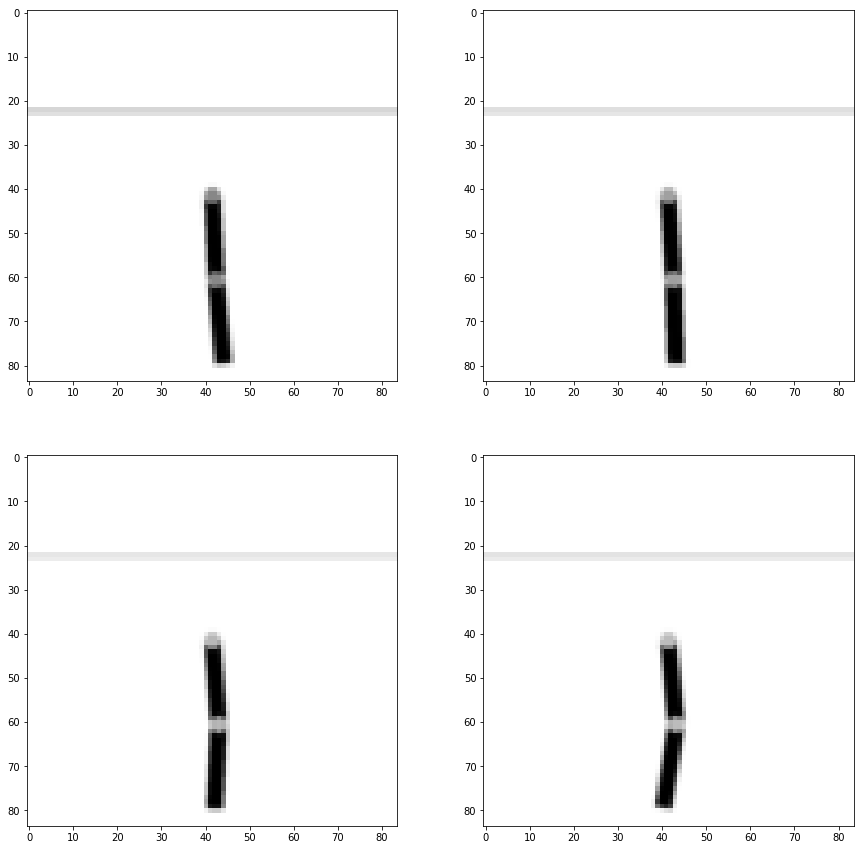

In [47]:
plt.rcParams['figure.figsize'] = (15,15)
env.reset()
img = env.render(mode='rgb_array')
env.close()
img = np.reshape(img, [500, 500, 3]).astype(np.float32)
img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
# img = img[:, :, 0] * 0.5 + img[:, :, 1] * 0.4 + img[:, :, 2] * 0.1
img = Image.fromarray(img)
resized_screen = img.resize((84, 84), Image.BILINEAR)
resized_screen = np.array(resized_screen)
x_t_1 = np.reshape(resized_screen, [84, 84, 1])
x_t_1 = x_t.astype(np.uint8)

env.step(0)
img = env.render(mode='rgb_array')
env.close()
img = np.reshape(img, [500, 500, 3]).astype(np.float32)
# img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
img = img[:, :, 0] * 0.5 + img[:, :, 1] * 0.4 + img[:, :, 2] * 0.1
img = Image.fromarray(img)
resized_screen = img.resize((84, 84), Image.BILINEAR)
resized_screen = np.array(resized_screen)
x_t_1 = np.reshape(resized_screen, [84, 84, 1])
x_t_1 = x_t_1.astype(np.uint8)

env.step(1)
img = env.render(mode='rgb_array')
env.close()
img = np.reshape(img, [500, 500, 3]).astype(np.float32)
# img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
img = img[:, :, 0] * 0.7 + img[:, :, 1] * 0.2 + img[:, :, 2] * 0.1
img = Image.fromarray(img)
resized_screen = img.resize((84, 84), Image.BILINEAR)
resized_screen = np.array(resized_screen)
x_t_2 = np.reshape(resized_screen, [84, 84, 1])
x_t_2 = x_t_2.astype(np.uint8)

env.step(0)
img = env.render(mode='rgb_array')
env.close()
img = np.reshape(img, [500, 500, 3]).astype(np.float32)
# img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
img = img[:, :, 0] * 0.5 + img[:, :, 1] * 0.4 + img[:, :, 2] * 0.1
img[img < 150] = 0
img[img > 230] = 255
img = Image.fromarray(img)
resized_screen = img.resize((84, 84), Image.BILINEAR)
resized_screen = np.array(resized_screen)
x_t_3 = np.reshape(resized_screen, [84, 84, 1])
x_t_3 = x_t_3.astype(np.uint8)


env.step(0)
img = env.render(mode='rgb_array')
env.close()
img = np.reshape(img, [500, 500, 3]).astype(np.float32)
# img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
img = img[:, :, 0] * 0.9 + img[:, :, 1] * 0.05 + img[:, :, 2] * 0.05
img = Image.fromarray(img)
resized_screen = img.resize((84, 84), Image.BILINEAR)
resized_screen = np.array(resized_screen)
x_t_4 = np.reshape(resized_screen, [84, 84, 1])
x_t_4 = x_t_4.astype(np.uint8)
plt.subplot(2,2,1)
plt.imshow(np.uint8(x_t_1[:,:,0]),cmap='gray')
# plt.imshow(np.uint8(x_t_1[:,:,0]))
plt.subplot(2,2,2)
plt.imshow(np.uint8(x_t_2[:,:,0]),cmap='gray')
# plt.imshow(np.uint8(x_t_2[:,:,0]))
plt.subplot(2,2,3)
plt.imshow(np.uint8(x_t_3[:,:,0]),cmap='gray')
# plt.imshow(np.uint8(x_t_3[:,:,0]))
plt.subplot(2,2,4)
plt.imshow(np.uint8(x_t_4[:,:,0]),cmap='gray')
# plt.imshow(np.uint8(x_t_4[:,:,0]))

In [28]:
env.close()

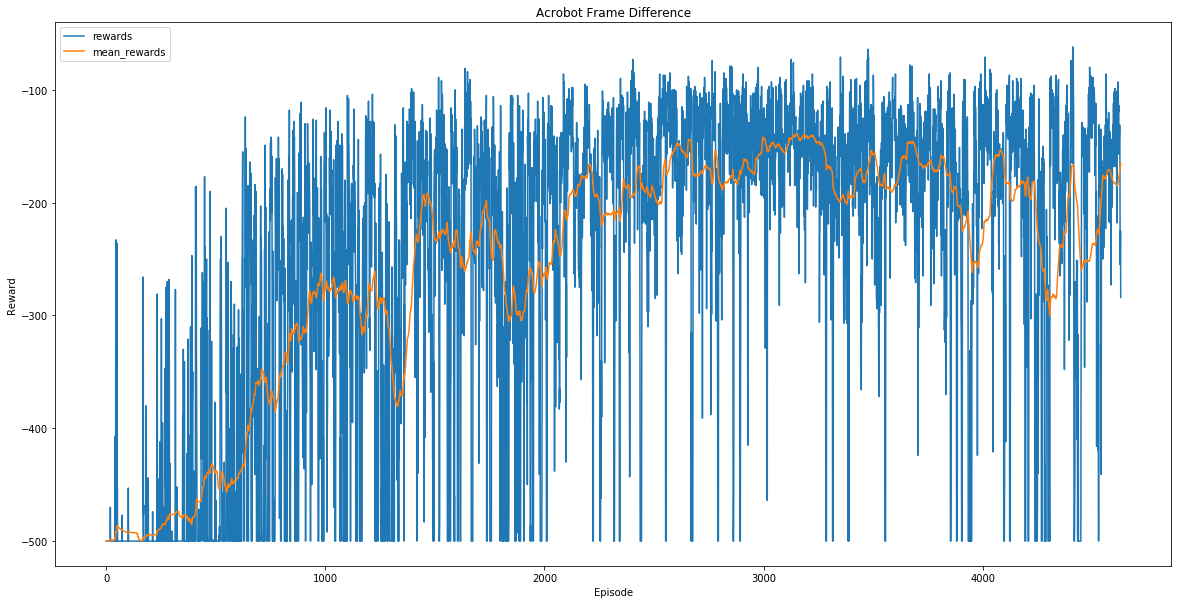

In [10]:
with open('./acrobot_agent_ckpt/frame_diff_training.status', 'rb') as fp:
    training_status = pickle.load(fp) 
    episodes_rewards = training_status['episodes_rewards']
    plt.rcParams['figure.figsize'] = (20, 10)
    plot_rewards(episodes_rewards, 100, title='Acrobot Frame Difference')

In [6]:
gym.logger.set_level(40)
env = gym.make("Acrobot-v1")
agent = AcrobotAgent(env, name='frame_diff', obs_represent='frame_diff', use_batch_norm=True)
play_acrobot(env, agent, num_episodes=10)

Using Frame-Difference representation for states
Checkpoint loaded successfully from  ./acrobot_agent_ckpt\acrobot_agent_frame_diff.pth
Created Agent for Acrobot-v1
Playing Acrobot-v1 with  frame_diff agent using Frame Difference
### Episode  1  ###
Episode:  1  Done, Reward:  -291.0  Episode Time: 5.00 secs
### Episode  2  ###
Episode:  2  Done, Reward:  -297.0  Episode Time: 5.00 secs
### Episode  3  ###
Episode:  3  Done, Reward:  -270.0  Episode Time: 4.53 secs
### Episode  4  ###
Episode:  4  Done, Reward:  -244.0  Episode Time: 4.12 secs
### Episode  5  ###
Episode:  5  Done, Reward:  -500.0  Episode Time: 8.35 secs
### Episode  6  ###
Episode:  6  Done, Reward:  -271.0  Episode Time: 4.55 secs
### Episode  7  ###
Episode:  7  Done, Reward:  -257.0  Episode Time: 4.32 secs
### Episode  8  ###
Episode:  8  Done, Reward:  -265.0  Episode Time: 4.45 secs
### Episode  9  ###
Episode:  9  Done, Reward:  -291.0  Episode Time: 4.88 secs
### Episode  10  ###
Episode:  10  Done, Reward:  

In [5]:
env.close()